In [30]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from pennylane import numpy as np
from utils import epsilon, evaluate
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from functools import partial

def operator_pool_G_extend(n_qubit):

    qubit_pool = []

    for i in range(n_qubit):
        for j in range(n_qubit):
            if i != j:
                qubit_pool.append(partial(PauliStringRotation, pauliString=('ZY', [i, j])))
                qubit_pool.append(partial(qml.CRX, wires=[i, j]))
                qubit_pool.append(partial(qml.CRY, wires=[i, j]))
                qubit_pool.append(partial(qml.CRZ, wires=[i, j]))

    for i in range(n_qubit):
        qubit_pool.append(partial(qml.RX, wires=i))
        qubit_pool.append(partial(qml.RY, wires=i))
        qubit_pool.append(partial(qml.RZ, wires=i))

    return qubit_pool

def PauliStringRotation(theta, pauliString: tuple[str, list[int]]):
    
    # Basis rotation
    for pauli, qindex in zip(*pauliString):
        if pauli == 'X':
            qml.RY(-np.pi / 2, wires=qindex)
        elif pauli == 'Y':
            qml.RX(np.pi / 2, wires=qindex)
    
    # CNOT layer
    for q, q_next in zip(pauliString[1][:-1], pauliString[1][1:]):
        qml.CNOT(wires=[q, q_next])
    
    # Z rotation
    qml.RZ(theta, pauliString[1][-1])

    # CNOT layer
    for q, q_next in zip(reversed(pauliString[1][:-1]), reversed(pauliString[1][1:])):
        qml.CNOT(wires=[q, q_next])

    # Basis rotation
    for pauli, qindex in zip(*pauliString):
        if pauli == 'X':
            qml.RY(np.pi / 2, wires=qindex)
        elif pauli == 'Y':
            qml.RX(-np.pi / 2, wires=qindex)

class adapt_DDQCL:

    def __init__(self, 
                 n_qubit: int, 
                 n_epoch: int, 
                 pool: list[tuple[str, list]],
                 lr=1e-2):
        
        self.n_qubit = n_qubit
        self.n_epoch = n_epoch
        self.pool = pool
        self.lr = lr
        self.threshold1 = 5e-3
        self.threshold2 = 1e-2
        self.Ng = 80
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.params = nn.ParameterDict({
            'append': nn.Parameter(torch.zeros(self.Ng), requires_grad=True),
            'freeze': nn.Parameter(torch.Tensor([]), requires_grad=False),
            'su2': nn.Parameter(torch.cat((torch.full((n_qubit, 1), np.pi/2), torch.zeros((n_qubit, 1))), dim=1), requires_grad=True)
        }).to(self.device)

        self.operatorID = {
            'append': [],
            'freeze': []
        }
        self.loss_history = []
        self.kl_history = []
        self.js_history = []

    def get_circuit(self, phi=None, append_gate=None):

        if not append_gate:
            for qindex in range(self.n_qubit):
                qml.RY(self.params['su2'][qindex, 0], wires=qindex)
                qml.RZ(self.params['su2'][qindex, 1], wires=qindex)

            for i, id in enumerate(self.operatorID['freeze']):
                gate = self.pool[id]
                gate(self.params['freeze'][i])

            for i, id in enumerate(self.operatorID['append']):
                gate = self.pool[id]
                gate(self.params['append'][i])
            
            return qml.probs(wires=list(range(self.n_qubit)))

        else:
            for qindex in range(self.n_qubit):
                qml.RY(self.params['su2'][qindex, 0].detach(), wires=qindex)
                qml.RZ(self.params['su2'][qindex, 1].detach(), wires=qindex)

            for i, id in enumerate(self.operatorID['freeze']):
                gate = self.pool[id]
                gate(self.params['freeze'][i].detach())
            
            for i, gate in enumerate(append_gate):
                gate(phi[i])
            
            return qml.probs(wires=list(range(self.n_qubit)))

    def select_operator(self, target_prob):
        
        dev = qml.device('default.qubit.torch', wires=self.n_qubit)
        
        circuit = self.get_circuit
        phi = nn.Parameter(torch.zeros(len(self.pool)), requires_grad=True)
        model = qml.QNode(circuit, dev, interface='torch', diff_method='backprop')
        prob = model(phi, self.pool).squeeze()
        cross_entropy = -torch.inner(target_prob, torch.log(prob + epsilon))* 2
        loss = cross_entropy
        loss.backward()
        grads = phi.grad.detach().cpu().numpy()
        
        grads = np.abs(grads)
        max_grad = np.max(grads)
        if max_grad * 0.3 > self.threshold1:
            self.Ng = np.sum(grads > max_grad * 0.3)
        else:
            self.Ng = np.sum(grads > self.threshold1)
        
        max_grad_indicies = np.argsort(grads)[::-1][:self.Ng]

        return grads[max_grad_indicies], max_grad_indicies
    
    def fit(self, target_prob):
        
        dev = qml.device('default.qubit.torch', wires=self.n_qubit)
        
        plt.ion()
        fig = plt.figure(figsize=(15, 9))
        gs = gridspec.GridSpec(2, 2, figure=fig)
        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[1, 0])
        ax3 = fig.add_subplot(gs[:, 1])

        for i_epoch in range(self.n_epoch):

            max_grads, max_grad_indicies = self.select_operator(target_prob)

            print(f'==== Found maximium gradient {max_grads} at index {max_grad_indicies} ====')
            if len(max_grads) == 0:
                print('Convergence criterion has reached, break the loop!')
                break

            self.operatorID['append'] = max_grad_indicies.tolist()
            self.params['append'] = nn.Parameter(torch.zeros(self.Ng), requires_grad=True).to(self.device)
            circuit = self.get_circuit
            model = qml.QNode(circuit, dev, interface='torch', diff_method='backprop')
            opt = optim.Adam(self.params.values(), lr=self.lr)

            while True:
                opt.zero_grad()
                prob = model()
                cross_entropy = -torch.inner(target_prob, torch.log(prob + epsilon))
                # neg_fildelity = -torch.sum(torch.sqrt(target_prob) * torch.sqrt(prob)) ** 2
                loss = cross_entropy
                loss.backward()
                opt.step()
                self.loss_history.append(loss.item())

                grad_vec = torch.cat((self.params['append'].grad, self.params['su2'].grad.view(-1)))
                grad_norm = torch.linalg.vector_norm(grad_vec)
                if grad_norm < self.threshold2:
                    break

            self.operatorID['freeze'] = self.operatorID['freeze'] + self.operatorID['append']
            self.params['freeze'] = torch.cat(
                (self.params['freeze'], self.params['append'].detach().clone())
            )

            kl_div, js_div = evaluate(target_prob.detach().cpu().numpy(), prob.detach().cpu().numpy())
            self.kl_history.append(kl_div)
            self.js_history.append(js_div)
            print(f'epoch: {i_epoch+1}, loss: {self.loss_history[-1]:.6f}, KL divergence: {kl_div:.6f}, JS divergence: {js_div:.6f}')
        
        print(qml.draw(model)())
        
        ax1.clear()
        ax1.plot(np.arange(i_epoch)+1, self.kl_history, label='KL divergence', color='red', marker='^', markerfacecolor=None)
        ax1.plot(np.arange(i_epoch)+1, self.js_history, label='JS divergence', color='blue', marker='x', markerfacecolor=None)
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('KL / JS divergence')
        ax1.grid()
        ax1.legend()

        ax2.clear()
        ax2.plot(np.arange(len(self.loss_history))+1, self.loss_history, color='green', marker='P')
        ax2.set_xlabel('iteration')
        ax2.set_ylabel('cross entropy loss')
        ax2.grid()

        ax3.clear()
        ax3.bar(np.arange(prob.shape[0])+1, target_prob.detach().cpu().numpy(), alpha=0.5, color='blue', label='target', width=100)
        ax3.bar(np.arange(prob.shape[0])+1, prob.detach().cpu().numpy(), alpha=0.5, color='red', label='approx', width=100)
        ax3.legend()
        
        plt.savefig('ADAPT-DDQCL-BAS4x4.png')
        
        plt.ioff()
        plt.show()

In [31]:
from data import DATA_HUB

n_qubit = 16
n_epoch = 100
pool = operator_pool_G_extend(n_qubit)
lr = 1e-2

data = torch.Tensor(DATA_HUB['bas 4x4']().get_data(10000000)).double().to(torch.device("cuda:0"))
model = adapt_DDQCL(n_qubit, n_epoch, pool, lr)

- BAS 4x4
- lr = 1e-1
- Ng = 25

==== Found maximium gradient [0.93460596 0.93460596 0.93460596 0.93460596 0.93460596 0.93460596
 0.93460596 0.93460596 0.93422991 0.93422991 0.93422991 0.93422991
 0.93422991 0.93422991 0.93422991 0.93422991 0.93371075 0.93371075
 0.93371075 0.93371075 0.93371075 0.93371075 0.93371075 0.93371075
 0.93364394 0.93364394 0.93364394 0.93364394 0.93364394 0.93364394
 0.93364394 0.93364394 0.93361437 0.93361437 0.93361437 0.93361437
 0.93361437 0.93361437 0.93361437 0.93361437 0.93361115 0.93361115
 0.93361115 0.93361115 0.93361115 0.93361115 0.93361115 0.93361115
 0.93304837 0.93304837 0.93304837 0.93304837 0.93304837 0.93304837
 0.93304837 0.93304837 0.93295753 0.93295753 0.93295753 0.93295753
 0.93295753 0.93295753 0.93295753 0.93295753 0.93291193 0.93291193
 0.93291193 0.93291193 0.93291193 0.93291193 0.93291193 0.93291193
 0.93285435 0.93285435 0.93285435 0.93285435 0.93285435 0.93285435
 0.93285435 0.93285435 0.93276435 0.93276435 0.93276435 0.93276435
 0.93276435 0.93276435 0.93276435

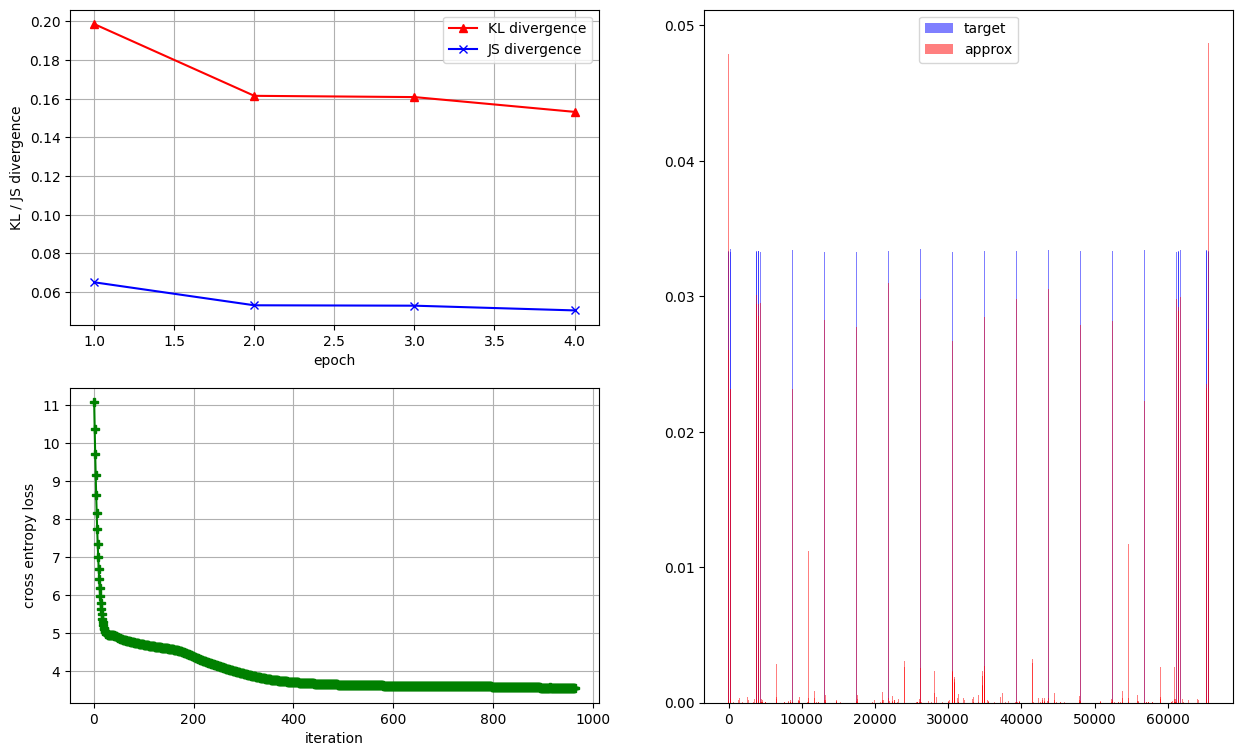

In [32]:
model.fit(data)

In [33]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from pennylane import numpy as np
from utils import epsilon, evaluate
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from functools import partial

def operator_pool_G_extend(n_qubit):

    qubit_pool = []

    for i in range(n_qubit):
        for j in range(n_qubit):
            if i != j:
                qubit_pool.append(partial(PauliStringRotation, pauliString=('ZY', [i, j])))
                qubit_pool.append(partial(qml.CRX, wires=[i, j]))
                qubit_pool.append(partial(qml.CRY, wires=[i, j]))
                qubit_pool.append(partial(qml.CRZ, wires=[i, j]))

    for i in range(n_qubit):
        qubit_pool.append(partial(qml.RX, wires=i))
        qubit_pool.append(partial(qml.RY, wires=i))
        qubit_pool.append(partial(qml.RZ, wires=i))

    return qubit_pool

def PauliStringRotation(theta, pauliString: tuple[str, list[int]]):
    
    # Basis rotation
    for pauli, qindex in zip(*pauliString):
        if pauli == 'X':
            qml.RY(-np.pi / 2, wires=qindex)
        elif pauli == 'Y':
            qml.RX(np.pi / 2, wires=qindex)
    
    # CNOT layer
    for q, q_next in zip(pauliString[1][:-1], pauliString[1][1:]):
        qml.CNOT(wires=[q, q_next])
    
    # Z rotation
    qml.RZ(theta, pauliString[1][-1])

    # CNOT layer
    for q, q_next in zip(reversed(pauliString[1][:-1]), reversed(pauliString[1][1:])):
        qml.CNOT(wires=[q, q_next])

    # Basis rotation
    for pauli, qindex in zip(*pauliString):
        if pauli == 'X':
            qml.RY(np.pi / 2, wires=qindex)
        elif pauli == 'Y':
            qml.RX(-np.pi / 2, wires=qindex)

class adapt_DDQCL:

    def __init__(self, 
                 n_qubit: int, 
                 n_epoch: int, 
                 pool: list[tuple[str, list]],
                 lr=1e-2):
        
        self.n_qubit = n_qubit
        self.n_epoch = n_epoch
        self.pool = pool
        self.lr = lr
        self.threshold = 1e-5
        self.Ng = 16
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.params = nn.ParameterDict({
            'append': nn.Parameter(torch.zeros(self.Ng), requires_grad=True),
            'freeze': nn.Parameter(torch.Tensor([]), requires_grad=False),
            'su2': nn.Parameter(torch.cat((torch.full((n_qubit, 1), np.pi/2), torch.zeros((n_qubit, 1))), dim=1), requires_grad=True)
        }).to(self.device)

        self.operatorID = {
            'append': [],
            'freeze': []
        }
        self.loss_history = []
        self.kl_history = []
        self.js_history = []

    def get_circuit(self, phi=None, append_gate=None):

        if not append_gate:
            for qindex in range(self.n_qubit):
                qml.RY(self.params['su2'][qindex, 0], wires=qindex)
                qml.RZ(self.params['su2'][qindex, 1], wires=qindex)

            for i, id in enumerate(self.operatorID['freeze']):
                gate = self.pool[id]
                gate(self.params['freeze'][i])

            for i, id in enumerate(self.operatorID['append']):
                gate = self.pool[id]
                gate(self.params['append'][i])
            
            return qml.probs(wires=list(range(self.n_qubit)))

        else:
            for qindex in range(self.n_qubit):
                qml.RY(self.params['su2'][qindex, 0].detach(), wires=qindex)
                qml.RZ(self.params['su2'][qindex, 1].detach(), wires=qindex)

            for i, id in enumerate(self.operatorID['freeze']):
                gate = self.pool[id]
                gate(self.params['freeze'][i].detach())
            
            append_gate(phi)
            
            return qml.probs(wires=list(range(self.n_qubit)))

    def select_operator(self, target_prob):
        
        grads = []
        dev = qml.device('default.qubit.torch', wires=self.n_qubit)
        
        for gate in self.pool:
            circuit = self.get_circuit
            phi = nn.Parameter(torch.zeros(1), requires_grad=True)
            model = qml.QNode(circuit, dev, interface='torch', diff_method='backprop')
            prob = model(phi, gate).squeeze()
            variation_distance = 1 / 2 * torch.sum(torch.abs(target_prob - prob))
            loss = 100 * variation_distance
            loss.backward()
            grads.append(phi.grad.item())
        
        grads = np.abs(grads)
        max_grad_indicies = np.argsort(grads)[::-1][:self.Ng]

        return grads[max_grad_indicies], max_grad_indicies
    
    def fit(self, target_prob):
        
        dev = qml.device('default.qubit.torch', wires=self.n_qubit)
        
        plt.ion()
        fig = plt.figure(figsize=(12, 9))
        gs = gridspec.GridSpec(2, 2, figure=fig)
        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[1, 0])
        ax3 = fig.add_subplot(gs[:, 1])

        for i_epoch in range(self.n_epoch):

            max_grads, max_grad_indicies = self.select_operator(target_prob)

            print(f'==== Found maximium gradient {max_grads} at index {max_grad_indicies} ====')
            if max_grads[0] < self.threshold:
                print('Convergence criterion has reached, break the loop!')
                break

            self.operatorID['append'] = max_grad_indicies.tolist()
            self.params['append'] = nn.Parameter(torch.zeros(self.Ng), requires_grad=True).to(self.device)
            circuit = self.get_circuit
            model = qml.QNode(circuit, dev, interface='torch', diff_method='backprop')
            opt = optim.Adam(self.params.values(), lr=self.lr)

            while True:
                opt.zero_grad()
                prob = model()
                variation_distance = 1 / 2 * torch.sum(torch.abs(target_prob - prob))
                loss = 100 * variation_distance
                loss.backward()
                opt.step()
                self.loss_history.append(loss.item())

                grad_vec = torch.cat((self.params['append'].grad, self.params['su2'].grad.view(-1)))
                grad_norm = torch.linalg.vector_norm(grad_vec)
                if grad_norm < self.threshold:
                    break

            self.operatorID['freeze'] = self.operatorID['freeze'] + self.operatorID['append']
            self.params['freeze'] = torch.cat(
                (self.params['freeze'], self.params['append'].detach().clone())
            )

            kl_div, js_div = evaluate(target_prob.detach().cpu().numpy(), prob.detach().cpu().numpy())
            self.kl_history.append(kl_div)
            self.js_history.append(js_div)
            print(f'epoch: {i_epoch+1}, loss: {self.loss_history[-1]:.6f}, KL divergence: {kl_div:.6f}, JS divergence: {js_div:.6f}')
        
        print(qml.draw(model)())
        
        ax1.clear()
        ax1.plot(np.arange(i_epoch)+1, self.kl_history, label='KL divergence', color='red', marker='^', markerfacecolor=None)
        ax1.plot(np.arange(i_epoch)+1, self.js_history, label='JS divergence', color='blue', marker='x', markerfacecolor=None)
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('KL / JS divergence')
        ax1.grid()
        ax1.legend()

        ax2.clear()
        ax2.plot(np.arange(len(self.loss_history))+1, self.loss_history, color='green', marker='P')
        ax2.set_xlabel('iteration')
        ax2.set_ylabel('negative fidelity')
        ax2.grid()

        ax3.clear()
        ax3.bar(np.arange(prob.shape[0])+1, target_prob.detach().cpu().numpy(), alpha=0.5, color='blue', label='target', width=100)
        ax3.bar(np.arange(prob.shape[0])+1, prob.detach().cpu().numpy(), alpha=0.5, color='red', label='approx', width=100)
        ax3.legend()
        
        plt.savefig('output.png')
        
        plt.ioff()
        plt.show()

In [34]:
from data import DATA_HUB

n_qubit = 16
n_epoch = 100
pool = operator_pool_G_extend(n_qubit)
lr = 1e-1

data = torch.Tensor(DATA_HUB['bas 4x4']().get_data(10000000)).double().to(torch.device("cuda:0"))
model = adapt_DDQCL(n_qubit, n_epoch, pool, lr)

==== Found maximium gradient [0.02136232 0.02136232 0.02136232 0.02136232 0.02136232 0.02136232
 0.02136232 0.02136232 0.02136232 0.02136232 0.02136232 0.02136232
 0.02136232 0.02136232 0.02136232 0.02136232] at index [  0 848 264 260 864 256 544 560 572 880 240 576 580 236 108 836] ====
epoch: 1, loss: 83.344178, KL divergence: 25.170126, JS divergence: 0.499828
==== Found maximium gradient [3.29315662e-06 3.29315662e-06 3.29315662e-06 3.29315662e-06
 3.29064710e-06 3.29064642e-06 3.29064551e-06 3.29063550e-06
 3.28570604e-06 3.27825546e-06 3.27080488e-06 3.27080488e-06
 3.26335430e-06 3.25066708e-06 3.25065616e-06 3.25065571e-06] at index [988  34 758 514 756 272 512  32 274 938 454 698 214  92 332 816] ====
Convergence criterion has reached, break the loop!
 0: ──RY(3.13)───RZ(0.94)────────────╭●────────────╭●──RX(1.57)────────────────────────────────────
 1: ──RY(2.86)───RZ(-0.04)──RX(1.57)─╰X──RZ(-0.42)─╰X──RX(-1.57)──RX(1.57)─────────────────────────
 2: ──RY(1.76)───RZ(0.08)───R

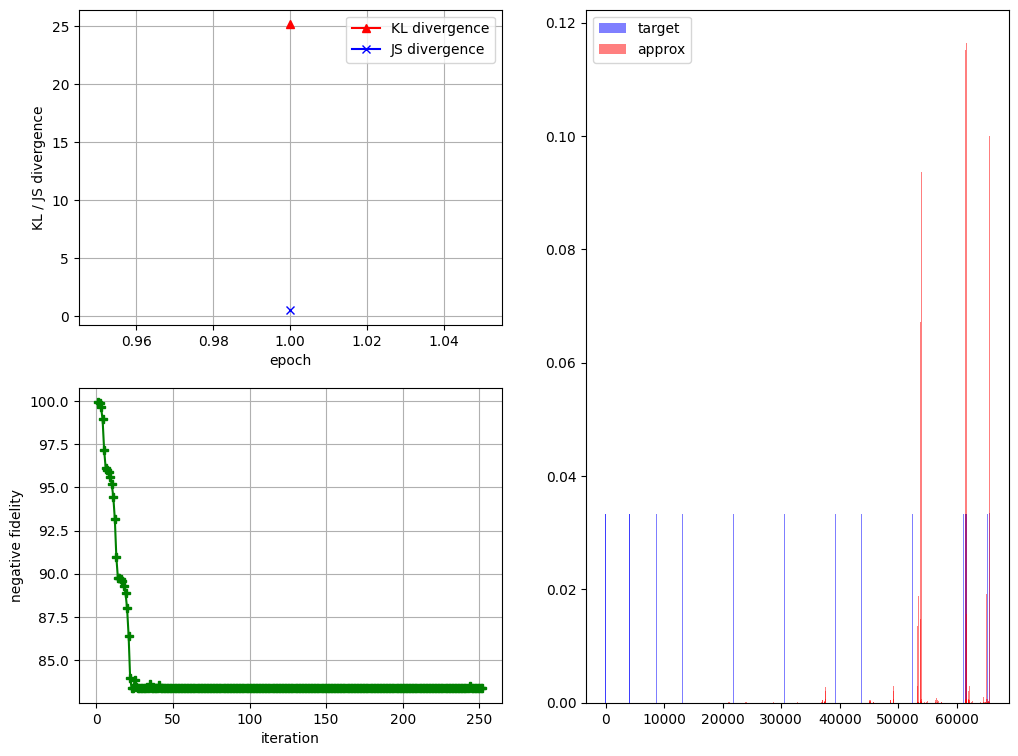

In [35]:
model.fit(data)